In [ ]:
!unzip "/content/trainingandtestdata.zip"

Archive:  /content/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import pandas as pd

m_cols = ['polarity','id','date','query','user','text']

train_data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", names = m_cols , encoding='latin-1')

In [ ]:
train_data.head(5)

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


1. Take the positive and the negative tweets only. Use Sklearn to split the dataset in 80%
training, 20% testing splits. Provide a nicely formatted summary of these splits,
containing their size) (15 points)



In [ ]:
negative_df = train_data[train_data['polarity'] == 0]

In [ ]:
positive_df = train_data[train_data['polarity'] == 4]

In [ ]:
tweets_neg_pos_df = pd.concat([negative_df,positive_df], axis=0)

In [ ]:
tweets_neg_pos_df.head(5)

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test= train_test_split(tweets_neg_pos_df.text,tweets_neg_pos_df.polarity, test_size=0.2, random_state=2361)

In [ ]:
print("Shape Training tweet Data: " + str(x_train.shape))
print("Shape Training polarity Data: " + str(y_train.shape))
print("Shape Test tweet Data: " + str(x_test.shape))
print("Shape Test polarity Data: " + str(y_test.shape))

Shape Training tweet Data: (1280000,)
Shape Training polarity Data: (1280000,)
Shape Test tweet Data: (320000,)
Shape Test polarity Data: (320000,)


2) Use the code from the previous classes to build the following models (15 points)

a) SVM using TF-IDF



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

def create_model(algorithm,vectorization,x_train_data,y_train_data):
  model = make_pipeline(vectorization,algorithm)
  model = model.fit(x_train_data,y_train_data)
  return model

In [ ]:
model_SVC_TF = create_model(LinearSVC(),TfidfVectorizer(),x_train,y_train)

b) Naive Bayes using TF-IDF

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_Naive_TF = create_model(MultinomialNB(),TfidfVectorizer(),x_train,y_train)

c) Random Forest using TF-IDF

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

model_RFC_TF = create_model(RandomForestClassifier(max_depth = 30),TfidfVectorizer(),x_train,y_train)

3) Use the code from the LSTM class to build a classifier for negative and positive
sentiment tweets. Train the model with the training data split. Once the model is built,
test it with the testing data split. Display the classifier report for this evaluation. Answer
the following question: What can you say about the performance of this model? (40
points)


In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array



In [ ]:
lab_to_sentiment = {0:0, 4:1}
def decode_label(label):
 return lab_to_sentiment[label]

y_train = y_train.apply(lambda x: decode_label(x))
y_test = y_test.apply(lambda x: decode_label(x))



In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_neg_pos_df.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 690961


In [ ]:

print("Maximum tweet length: {}".format(len(max((tweets_neg_pos_df.text), key=len))))
print("Minimum tweet length: {}".format(len(min((tweets_neg_pos_df.text), key=len))))
result = [len(x) for x in tweets_neg_pos_df.text]
print("Mean tweet length: {}".format(np.mean(result)))


print("")
print("Machine readable tweets")
print("  tweet Text: " + str(x_train[60]))
print("  tweet Sentiment: " + str(y_train[60]))


Maximum tweet length: 374
Minimum tweet length: 6
Mean tweet length: 74.09011125

Machine readable tweets
  tweet Text: @BatManYNG I miss my ps3, it's out of commission  Wutcha playing? Have you copped 'Blood On The Sand'?
  tweet Sentiment: 0


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 374
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 374)
Testing X Shape: (320000, 374)


In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

model = tf.keras.models.Sequential()


model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = MAX_SEQUENCE_LENGTH # Length of input sequences
    )
)


model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)


model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 374, 32)           22110752  
_________________________________________________________________
dropout (Dropout)            (None, 374, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 22,119,105
Trainable params: 22,119,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train , batch_size=256, epochs=3,validation_split=0.2, verbose=1)

Epoch 1/3
4000/4000 [==============================] - 2287s 571ms/step - loss: 0.4721 - accuracy: 0.7736 - val_loss: 0.4010 - val_accuracy: 0.8168
Epoch 2/3
4000/4000 [==============================] - 2293s 573ms/step - loss: 0.3488 - accuracy: 0.8470 - val_loss: 0.4086 - val_accuracy: 0.8149
Epoch 3/3
4000/4000 [==============================] - 2214s 554ms/step - loss: 0.2737 - accuracy: 0.8858 - val_loss: 0.4322 - val_accuracy: 0.8081


LSTM is way efficient which is evident through it's accuracy values.

In [ ]:
import numpy


from sklearn.metrics import classification_report
predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=[0,1]))

4. Compare all models together in terms of Precision, Recall and F1 score. Put all of
these numbers in a nicely formatted dataframe.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test= train_test_split(tweets_neg_pos_df.text,tweets_neg_pos_df.polarity, test_size=0.2, random_state=2361)

In [ ]:
label_SVC = model_SVC_TF.predict(x_test)
label_Naive_TF = model_Naive_TF.predict(x_test)
label_RFC_TF = model_RFC_TF.predict(x_test)

In [ ]:
import sklearn
F1_Scores = [sklearn.metrics.f1_score(label_SVC,y_test , average='macro'),
             sklearn.metrics.f1_score(label_Naive_TF,y_test , average='macro'),
             sklearn.metrics.f1_score(label_RFC_TF,y_test, average='macro')]

Precision = [sklearn.metrics.precision_score(y_test,label_SVC, pos_label = 4),
             sklearn.metrics.precision_score(y_test,label_Naive_TF, pos_label = 4),
             sklearn.metrics.precision_score(y_test,label_RFC_TF, pos_label = 4)]

Recall = [sklearn.metrics.recall_score(y_test,label_SVC,pos_label = 4),
          sklearn.metrics.recall_score(y_test,label_Naive_TF,pos_label = 4),
          sklearn.metrics.recall_score(y_test,label_RFC_TF,pos_label = 4)]
 

In [ ]:
model_name = ['SVM','Naive','RFC']
performance = pd.DataFrame()
performance['Model_name'] = model_name
performance['Precision'] = Precision
performance['Recall'] = Recall
performance['Macro_F1-Score'] = F1_Scores

In [ ]:
performance

,Model_name,Precision,Recall,Macro_F1-Score
0,SVM,0.793902,0.800615,0.796381
1,Naive,0.800344,0.728078,0.772759
2,RFC,0.733351,0.769509,0.744698


 Answer the following questions: Which model performs the best? Why do you think this is? What do you think you can do to
improve performance?

Text(0.5, 1.0, 'Sentiment Data Distribution')

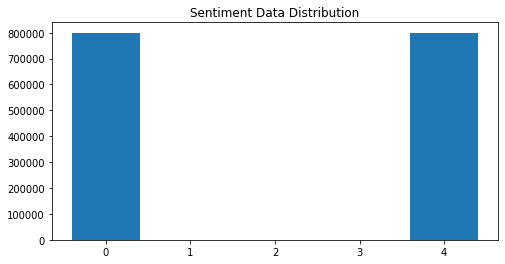

In [ ]:
import matplotlib.pyplot as plt
val_count = tweets_neg_pos_df.polarity.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

As we are comparing amongst the classifiers of a balanced dataset, Precision and recall are very much likely to be considered than F-score. Low precision and high recall rates are seen in SVM and RFC but based on values we can conclude that SVM is the better classifer amongst above three models.

But when compared, LSTM is way efficient which is evident through it's accuracy values. 

yes, I do think we can improve performance by cleaning the tweets and avoiding noise data.

5. Add to the comparison of #4 a the manually calculated precision, recall and F1 score
using VADER and their suggested defaults to categorize the test split tweets in positive
or negative. Answer the following questions: Is this approach as good as the previous
ones? Why do you think this is? (30 points

In [ ]:
import nltk
import numpy
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
sid = SentimentIntensityAnalyzer()

#Vader_df = tweets_neg_pos_df.copy()
#Vader_df.drop(columns=['id','date','query','user'],axis = 0,inplace=True)

Vader_df=pd.DataFrame(x_test,columns=['text'])

compound = []
pos=[]
neu=[]
neg = []

for row in Vader_df['text']:
  #print(row)
  vs = sid.polarity_scores(row)

  compound.append(vs['compound'])
  pos.append(vs['pos'])
  neu.append(vs['neu'])
  neg.append(vs['neg'])


In [ ]:
Vader_df['compound'] = compound
Vader_df['pos'] = pos
Vader_df['neu'] = neu
Vader_df['neg'] = neg

In [ ]:
Vader_df

,text,compound,pos,neu,neg
402563,is going to bed now after a day of hard work -...,0.2732,0.120,0.813,0.067
1558129,@lilxicanita aww mecheee you can be my friend....,0.0000,0.000,1.000,0.000
1415201,having my big brother open for me is a dream c...,0.5905,0.221,0.779,0.000
1112565,acting going well. will reach goal by God's gr...,0.6124,0.500,0.500,0.000
706645,@morganmovement what?! Wtf happened?! I'm doin...,-0.6950,0.000,0.760,0.240
...,...,...,...,...,...
1087432,@mileycyrus http://twitpic.com/5ppwd - I have ...,0.0000,0.000,1.000,0.000
1520516,"@gin_lady thanks, lots of sleep and knitting s...",0.6808,0.444,0.556,0.000
728046,just watched like a three hour movie arizona i...,0.3612,0.161,0.839,0.000
285604,I saw all the 'tussen de oren' episodes and f...,-0.7316,0.000,0.745,0.255


In [ ]:
default = 0.05
sentiment = []
for row in Vader_df['compound']:
  if row >= default:
    sentiment.append('Positive')
  elif row < default:
    sentiment.append('Negative')

In [ ]:
Vader_df['sentiment'] = sentiment

In [ ]:
Vader_df

,text,compound,pos,neu,neg,sentiment
402563,is going to bed now after a day of hard work -...,0.2732,0.120,0.813,0.067,Positive
1558129,@lilxicanita aww mecheee you can be my friend....,0.0000,0.000,1.000,0.000,Negative
1415201,having my big brother open for me is a dream c...,0.5905,0.221,0.779,0.000,Positive
1112565,acting going well. will reach goal by God's gr...,0.6124,0.500,0.500,0.000,Positive
706645,@morganmovement what?! Wtf happened?! I'm doin...,-0.6950,0.000,0.760,0.240,Negative
...,...,...,...,...,...,...
1087432,@mileycyrus http://twitpic.com/5ppwd - I have ...,0.0000,0.000,1.000,0.000,Negative
1520516,"@gin_lady thanks, lots of sleep and knitting s...",0.6808,0.444,0.556,0.000,Positive
728046,just watched like a three hour movie arizona i...,0.3612,0.161,0.839,0.000,Positive
285604,I saw all the 'tussen de oren' episodes and f...,-0.7316,0.000,0.745,0.255,Negative


In [ ]:
y_pred = Vader_df.sentiment

lab_to_sentiment = {0:"Negative", 4:"Positive"}
def decode_label(label):
  return lab_to_sentiment[label]

y_test = y_test.apply(lambda x: decode_label(x))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[109990,  50008],
       [ 61642,  98360]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
# Recall
from sklearn.metrics import recall_score
recall= recall_score(y_test, y_pred,pos_label='Positive')
# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred,pos_label='Positive')

In [ ]:
F1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
F1

0.6379349482764213

Bonus (30 points): Try the following things to improve the LSTM model:


1) Use 90% training data, 10% testing


In [ ]:
x_trainn, x_testn ,y_trainn, y_testn= train_test_split(tweets_neg_pos_df.text,tweets_neg_pos_df.polarity, test_size=0.1, random_state=2361)


In [ ]:
lab_to_sentiment = {0:0, 4:1}
def decode_label(label):
 return lab_to_sentiment[label]

y_trainn = y_trainn.apply(lambda x: decode_label(x))
y_testn = y_testn.apply(lambda x: decode_label(x))


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_neg_pos_df.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 690961


In [ ]:
import numpy as np


print("Maximum tweet length: {}".format(len(max((tweets_neg_pos_df.text), key=len))))
print("Minimum tweet length: {}".format(len(min((tweets_neg_pos_df.text), key=len))))
result = [len(x) for x in tweets_neg_pos_df.text]
print("Mean tweet length: {}".format(np.mean(result)))


print("")
print("Machine readable tweets")
print("  tweet Text: " + str(x_trainn[60]))
print("  tweet Sentiment: " + str(y_trainn[60]))

from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 374
x_trainn = pad_sequences(tokenizer.texts_to_sequences(x_trainn), maxlen = MAX_SEQUENCE_LENGTH)
x_testn = pad_sequences(tokenizer.texts_to_sequences(x_testn), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_trainn.shape)
print("Testing X Shape:",x_testn.shape)

Maximum tweet length: 374
Minimum tweet length: 6
Mean tweet length: 74.09011125

Machine readable tweets
  tweet Text: @BatManYNG I miss my ps3, it's out of commission  Wutcha playing? Have you copped 'Blood On The Sand'?
  tweet Sentiment: 0
Training X Shape: (1440000, 374)
Testing X Shape: (160000, 374)


In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

model = tf.keras.models.Sequential()


model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = MAX_SEQUENCE_LENGTH # Length of input sequences
    )
)


model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)


model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 374, 32)           22110752  
_________________________________________________________________
dropout (Dropout)            (None, 374, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 22,119,105
Trainable params: 22,119,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_trainn, y_trainn , batch_size=256, epochs=3,validation_split=0.2, verbose=1)

Epoch 1/3
4500/4500 [==============================] - 1815s 403ms/step - loss: 0.4686 - accuracy: 0.7752 - val_loss: 0.3954 - val_accuracy: 0.8200
Epoch 2/3
4500/4500 [==============================] - 1803s 401ms/step - loss: 0.3464 - accuracy: 0.8486 - val_loss: 0.4075 - val_accuracy: 0.8159
Epoch 3/3
4500/4500 [==============================] - 1821s 405ms/step - loss: 0.2763 - accuracy: 0.8849 - val_loss: 0.4315 - val_accuracy: 0.8097


2) Remove stopwords from the tweets.


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tweets_neg_pos_df['tweets_no_stopwords'] = tweets_neg_pos_df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

In [ ]:

print("Maximum tweet length: {}".format(len(max((tweets_neg_pos_df.text), key=len))))
print("Minimum tweet length: {}".format(len(min((tweets_neg_pos_df.text), key=len))))
result = [len(x) for x in tweets_neg_pos_df.text]
print("Mean tweet length: {}".format(np.mean(result)))


print("")
print("Machine readable tweets")
print("  tweet Text: " + str(x_train[60]))
print("  tweet Sentiment: " + str(y_train[60]))


Maximum tweet length: 374
Minimum tweet length: 6
Mean tweet length: 74.09011125

Machine readable tweets
  tweet Text: @BatManYNG I miss my ps3, it's out of commission  Wutcha playing? Have you copped 'Blood On The Sand'?
  tweet Sentiment: 0


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 374
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 374)
Testing X Shape: (320000, 374)


In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

model = tf.keras.models.Sequential()


model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = MAX_SEQUENCE_LENGTH # Length of input sequences
    )
)


model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)


model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 374, 32)           22110752  
_________________________________________________________________
dropout_2 (Dropout)          (None, 374, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,119,105
Trainable params: 22,119,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train , batch_size=256, epochs=3,validation_split=0.2, verbose=1)

Epoch 1/3
4000/4000 [==============================] - 1656s 414ms/step - loss: 0.4725 - accuracy: 0.7733 - val_loss: 0.4039 - val_accuracy: 0.8162
Epoch 2/3
1825/4000 [============>.................] - ETA: 14:00 - loss: 0.3512 - accuracy: 0.8452

3) Remove all user mentions for the tweets (@something)
Compare all three new models in terms of their precision, recall and F1 score. Answer the
following questions: Did this change the results in any way? Why do you think so

3) Remove all user mentions for the tweets (@something) Compare all three new models in terms of their precision, recall and F1 score. 

In [ ]:
tweets_no_user_mentions = []
import re

for unwanted in tweets_neg_pos_df.text :
    #print(unwanted)
    fixed_doc = re.sub(r"@(\w+)", '', unwanted)
    tweets_no_user_mentions.append(str(fixed_doc))


In [ ]:
tweets_neg_pos_df['tweets_no_user_mentions'] = tweets_no_user_mentions

In [ ]:
tweets_neg_pos_df['tweets_no_user_mentions'].head(5)

0     http://twitpic.com/2y1zl - Awww, that's a bum...
1    is upset that he can't update his Facebook by ...
2     I dived many times for the ball. Managed to s...
3      my whole body feels itchy and like its on fire 
4     no, it's not behaving at all. i'm mad. why am...
Name: tweets_no_user_mentions, dtype: object

In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array



In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test= train_test_split(tweets_neg_pos_df.tweets_no_user_mentions,tweets_neg_pos_df.polarity, test_size=0.2, random_state=2361)

In [ ]:
lab_to_sentiment = {0:0, 4:1}
def decode_label(label):
 return lab_to_sentiment[label]

y_train = y_train.apply(lambda x: decode_label(x))
y_test = y_test.apply(lambda x: decode_label(x))



In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_neg_pos_df.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 690961


In [ ]:

print("Maximum tweet length: {}".format(len(max((tweets_neg_pos_df.text), key=len))))
print("Minimum tweet length: {}".format(len(min((tweets_neg_pos_df.text), key=len))))
result = [len(x) for x in tweets_neg_pos_df.text]
print("Mean tweet length: {}".format(np.mean(result)))


print("")
print("Machine readable tweets")
print("  tweet Text: " + str(x_train[60]))
print("  tweet Sentiment: " + str(y_train[60]))


Maximum tweet length: 374
Minimum tweet length: 6
Mean tweet length: 74.09011125

Machine readable tweets
  tweet Text:  I miss my ps3, it's out of commission  Wutcha playing? Have you copped 'Blood On The Sand'?
  tweet Sentiment: 0


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 374
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 374)
Testing X Shape: (320000, 374)


In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

model = tf.keras.models.Sequential()


model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = MAX_SEQUENCE_LENGTH # Length of input sequences
    )
)


model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)


model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 374, 32)           22110752  
_________________________________________________________________
dropout (Dropout)            (None, 374, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 22,119,105
Trainable params: 22,119,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train , batch_size=256, epochs=3,validation_split=0.2, verbose=1)

Epoch 1/3
3675/4000 [==========================>...] - ETA: 1:11 - loss: 0.3759 - accuracy: 0.8317

In [ ]:
# Get Model Predictions for test data
def lst_of_lst(lst):
    return [[el] for el in lst]

from sklearn.metrics import classification_report
predicted_classes = model.predict_classes(x_test)
print(classification_report(lst_of_lst(y_test), predicted_classes, target_names=[0,1]))